In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_ubyte
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import trange, tqdm

from src.data.ucmerced_dataset import UcMercedDataset
from src.settings import TRAIN_DATA_DIRECTORY, TEST_DATA_DIRECTORY
from src.measures import anmrr

In [4]:
train_dataset = UcMercedDataset(TRAIN_DATA_DIRECTORY)
test_dataset = UcMercedDataset(TEST_DATA_DIRECTORY)

In [5]:
x_train = np.empty(shape=(train_dataset.__len__(), 256, 256, 3))
y_train = np.empty(shape=(train_dataset.__len__(), ), dtype=np.int)

x_test = np.empty(shape=(test_dataset.__len__(), 256, 256, 3))
y_test = np.empty(shape=(test_dataset.__len__(), ), dtype=np.int)

for idx in trange(train_dataset.__len__()):
    item = train_dataset.__getitem__(idx)

    x_train[idx] = item['a']
    y_train[idx] = item['a_y']

for idx in trange(test_dataset.__len__()):
    item = test_dataset.__getitem__(idx)

    x_test[idx] = item['a']
    y_test[idx] = item['a_y']

100%|██████████| 411/411 [00:03<00:00, 102.95it/s]


In [6]:
sift = cv2.SIFT_create()

In [7]:
def get_descriptors(images):
    desc = []

    for img in tqdm(images, desc="Calculating SIFT descriptors"):
        cv_img = img_as_ubyte(img)
        cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2GRAY)
        _, d = sift.detectAndCompute(cv_img, None)
        if d is not None:
            desc.append(d)

    return desc

def encode_as_bovw(x: np.ndarray, trained_kmeans: KMeans) -> np.ndarray:
    descriptors = get_descriptors(x)

    res = np.empty(shape=(x.shape[0], trained_kmeans.n_clusters))

    for idx, desc in tqdm(
            enumerate(descriptors),
            total=len(descriptors),
            desc="Encoding as BOVW"):
        words = trained_kmeans.predict(desc)
        bovw, _ = np.histogram(words, bins=range(trained_kmeans.n_clusters + 1))
        res[idx] = bovw / desc.shape[0]

    return res

In [8]:
stacked_train_descriptors = np.vstack(get_descriptors(x_train))

Calculating SIFT descriptors: 100%|██████████| 1645/1645 [01:16<00:00, 21.42it/s]


In [32]:
CLUSTERS = 100
SAMPLES_COUNT = 100000

In [33]:
%%time

k_means = KMeans(n_clusters=CLUSTERS)

k_means.fit(stacked_train_descriptors[np.random.choice(
    stacked_train_descriptors.shape[0],
    SAMPLES_COUNT,
    replace=False
)])


CPU times: user 16min 1s, sys: 6min 46s, total: 22min 47s
Wall time: 7min 32s


KMeans(n_clusters=100)

In [34]:
x_test_encoded = encode_as_bovw(x_test, k_means)

Encoding as BOVW: 100%|██████████| 410/410 [00:12<00:00, 32.82it/s]


In [35]:
anmrr(x_test_encoded, y_test[:, None], euclidean_distances)

0.6613264106336857

In [36]:
n_neighbours = NearestNeighbors()
n_neighbours.fit(x_test_encoded)

NearestNeighbors()

In [41]:
QUERY_IMAGE_IDX = 162

In [42]:
query_image = x_test_encoded[QUERY_IMAGE_IDX].reshape(1, -1)
_, query_result_idx = n_neighbours.kneighbors(query_image, n_neighbors=11)

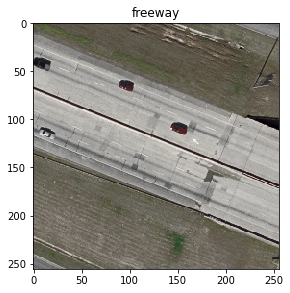

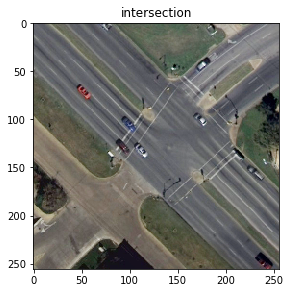

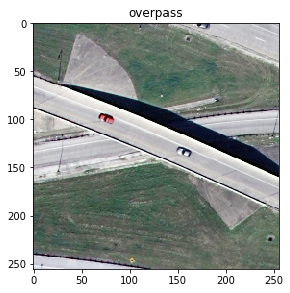

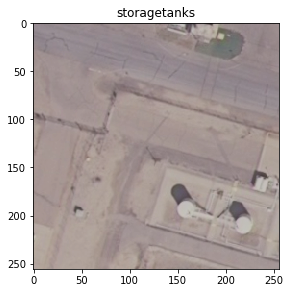

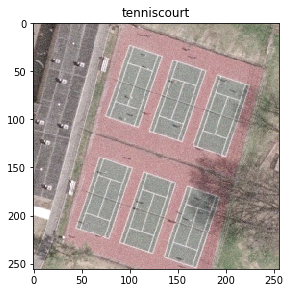

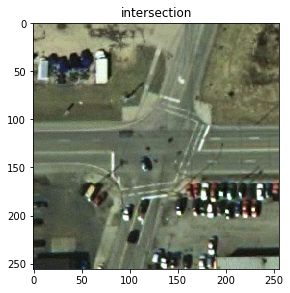

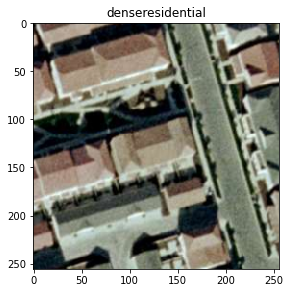

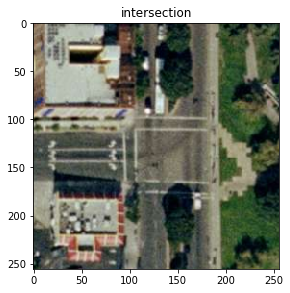

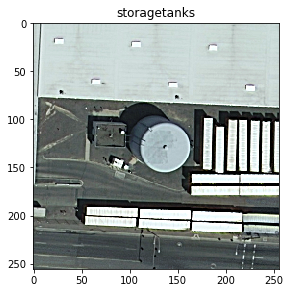

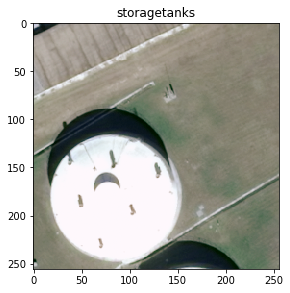

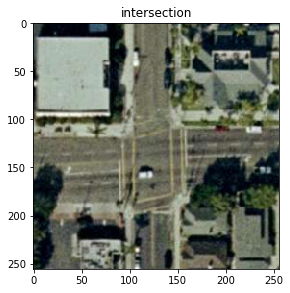

In [43]:
for idx in query_result_idx.squeeze():
    io.imshow(x_test[idx])
    plt.title(test_dataset.label_name_mapping[y_test[idx]])
    plt.show()